In [76]:
import string
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer




def most_tags(dataframe, nbr_tags: int = 120):
    vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: str(x).split(" "))
    tag_vect = vectorizer.fit_transform(dataframe["Tags"])
    tags = vectorizer.get_feature_names_out()
    freqs = tag_vect.sum(axis=0).A1
    result = list(zip(tags, freqs))
    tag_counts = pd.DataFrame(result, columns=['tag', 'tag_counts']).sort_values(['tag_counts'], ascending=False)

    tags_kept = list(tag_counts['tag'].head(nbr_tags))

    print(f"Top ten tags  : {tags_kept[:10]}")
    print(f"Number of tags kept : {len(tags_kept)}")

    from tqdm import tqdm

    for le in tqdm(range(dataframe.shape[0])):
        a = []
        b = dataframe['Tags'][le].split(" ")

        for i in range(len(b)):
            for j in tags_kept:
                temp = b[i].strip()  #Stripping the white-spaces present(if any) around the tag
                if temp == j:
                    a.append(j)
        if a:
            dataframe['Tags'][le] = " ".join(a)
        else:
            dataframe['Tags'][le] = np.nan
    dataframe = dataframe.dropna()
    print(dataframe.shape)
    return dataframe


import re
from nltk.corpus import stopwords
def decontract(sentence):
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence
def cleanPunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', '', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub("", sentence)
df = pd.read_csv('../QueryResults.csv')
#removes characters repeated

wordnet_lemmatizer = WordNetLemmatizer()
df['CleanTitle'] = df['Title'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word, pos="v") for word in x.split() if word not in (stopwords.words("english"))]))


df['CleanTitle'] = df['CleanTitle'].apply(lambda x: decontract(x))
df['CleanTitle'] = df['CleanTitle'].apply(lambda x: cleanPunc(x))
df['CleanTitle'] = df['CleanTitle'].apply(lambda x: keepAlpha(x))
df['CleanTitle'] = df['CleanTitle'].apply(lambda x: re.sub(r'(\w)(\1{2,})', r'\1',x))

In [77]:
df['CleanTitle']

0        Android Studio  Could get unknown property VER...
1        How mock history push new React Router Hooks u...
2                           C Converting List Chars String
3        Implementing efficient audit trail record chan...
4                How change number row textarea use jQuery
                               ...                        
49995           How ensure trail directory separator paths
49996    Visualize Jenkins pipeline multibranch pipelin...
49997                      How Update JSONArray value java
49998                    AngularJS route provider change F
49999                                     How CDN DNS Work
Name: CleanTitle, Length: 50000, dtype: object

In [78]:

df["Tags"] = df["Tags"].str.lstrip('<').str.replace('<', ' ').str.replace('>', '')
df.head()

df['CleanTitle'] = df['Title'].apply(lambda x: re.sub(r'(\w)(\1{2,})', r'\1',x))
data = most_tags(df)

data.drop(
    data[df['Tags'].isin(data['Tags'].value_counts().loc[lambda x: x == 1].reset_index()['index'].tolist())].index,
    inplace=True)
data.shape

/home/alex/Bureau/OpenClassroom/projet_5/venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top ten tags  : ['c#', 'java', 'python', 'javascript', 'c++', '.net', 'android', 'php', 'html', 'jquery']
Number of tags kept : 120


100%|██████████| 50000/50000 [00:05<00:00, 8959.35it/s]

(38745, 9)



/tmp/ipykernel_4026/619474544.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[df['Tags'].isin(data['Tags'].value_counts().loc[lambda x: x == 1].reset_index()['index'].tolist())].index,


(35929, 9)

In [79]:
data.head()

Title  \
0  Android Studio : "Could not get unknown proper...   
1  How to mock history.push with the new React Ro...   
3  Implementing efficient audit trail of record c...   
4  How to change the number of rows in the textar...   
5                Firebase 401 unauthorized error FCM   

                                                Body                Tags  \
0  <p>I am a newbie with Android Studio. I am try...        java android   
1  <p>I am trying to mock <code>history.push</cod...             reactjs   
3  <p>I have a quite common design problem: I nee...  python performance   
4  <p>I have a textarea with 5 lines. I want to s...   javascript jquery   
5  <p>I'm trying to test out Firebase Cloud messa...             android   

         Id  Score  ViewCount  FavoriteCount  AnswerCount  \
0  40420705      6      51645            0.0            3   
1  58524183     53      60110            0.0            3   
3   4417130      6       2075            0.0            1   
4   4417161     21      32115            0.0            3   
5  37633188     77     115365            0.0           10   

                                          CleanTitle  
0  Android Studio : "Could not get unknown proper...  
1  How to mock history.push with the new React Ro...  
3  Implementing efficient audit trail of record c...  
4  How to change the number of rows in the textar...  
5                Firebase 401 unauthorized error FCM

In [80]:
data['token_size'] = data['CleanTitle'].apply(lambda x: len(x.split(' ')))
data = data.loc[data['token_size'] < 60]
# data = data.sample(n= 50000)

In [81]:
# Construct a vocabulary
class ConstructVocab():

    def __init__(self, sentences):
        self.sentences = sentences
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()

    def create_index(self):
        for sent in self.sentences:
            self.vocab.update(sent.split(' '))

        #sort vacabulary
        self.vocab = sorted(self.vocab)

        #add a padding token with index 0
        self.word2idx['<pad>'] = 0

        #word to index mapping
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1 # 0 is the pad

        #index to word mapping
        for word, index in self.word2idx.items():
            self.idx2word[index] = word
inputs = ConstructVocab(data['CleanTitle'].values.tolist())

In [82]:
input_tensor = [[inputs.word2idx[s] for s in es.split(' ')] for es in data['CleanTitle']]

In [83]:
def max_length(tensor):
    return max(len(t) for t in tensor)
max_length_input = max_length(input_tensor)
def pad_sequences(x, max_len):
    padded = np.zeros((max_len), dtype=np.int64)

    if len(x) > max_len: padded[:] = x[:max_len]
    else: padded[:len(x)] = x

    return padded
input_tensor = [pad_sequences(x, max_length_input) for x in input_tensor]

In [84]:
from sklearn import preprocessing
rates = list(set(data.Score.unique()))
num_rates = len(rates)

mlb = preprocessing.MultiLabelBinarizer()
data_labels = [set(rat) & set(rates) for rat in data['Tags'].values]
# data_labels = [set(rat) & set(rates) for rat in data[['Tags']].values]
bin_rates = mlb.fit_transform(data["Tags"].apply(lambda x: x.split(" ")))
target_tensor = np.array(bin_rates.tolist())

In [85]:
# data_labels = [set(rat) & set(rates) for rat in data['Tags'].values]
# bin_rates.classes
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'amazon-web-services', 'android',
       'angular', 'angularjs', 'apache', 'arrays', 'asp.net',
       'asp.net-mvc', 'authentication', 'bash', 'c', 'c#', 'c++', 'c++11',
       'caching', 'cocoa', 'cocoa-touch', 'css', 'database', 'date',
       'datetime', 'debugging', 'delphi', 'design-patterns', 'django',
       'docker', 'eclipse', 'emacs', 'entity-framework', 'excel',
       'exception', 'file', 'firebase', 'flutter', 'function', 'gcc',
       'generics', 'git', 'haskell', 'hibernate', 'html', 'http', 'image',
       'ios', 'ios7', 'iphone', 'java', 'javascript', 'jquery', 'json',
       'language-agnostic', 'linq', 'linux', 'list', 'logging', 'macos',
       'math', 'memory', 'multithreading', 'mysql', 'node.js', 'numpy',
       'objective-c', 'oop', 'optimization', 'oracle', 'pandas',
       'parsing', 'performance', 'perl', 'php', 'postgresql',
       'powershell', 'python', 'python-3.x', 'qt', 'r', 'reactjs',
       'reflection', 'regex', '

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=1000)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=1000)

In [87]:
embedding_dim = 256
units = 1024
vocab_inp_size = len(inputs.word2idx)
target_size = len(target_tensor[0])

In [100]:
print(target_size)

120


In [88]:
import tensorflow as tf
# import keras.backend.tensorflow_backend as tfback
from keras import backend as K

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns a list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

# tfback._get_available_gpus = _get_available_gpus
# K.tensorflow_backend._get_available_gpus()
print(tf.config.list_physical_devices('GPU'))

[]


In [89]:

print(tf.test.is_built_with_cuda)

<function is_built_with_cuda at 0x7f2fe1808c10>


In [90]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [91]:
from keras.layers import Dense, Embedding, Dropout, GRU
from keras.models import Sequential
from keras import layers
def create_model():

    model = Sequential()
    model.add(Embedding(vocab_inp_size, embedding_dim, input_length=max_length_input))
    model.add(Dropout(0.5))
    model.add(GRU(units))
    model.add(layers.Dense(120, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [92]:
import time
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.process_time() -self.timetaken))

In [93]:
# timetaken = timecallback()
# model = create_model()
# history = model.fit(pd.DataFrame(X_train), y_train,
#                     epochs=10,
#                     verbose=True,
#                     validation_data=(pd.DataFrame(X_val), y_val),
#                     batch_size=64,
#                     callbacks = [timetaken])

In [94]:
# Use Dataset class to represent the dataset object
from torch.utils.data import Dataset, DataLoader
class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        self.length = [np.sum(1 - np.equal(x,0)) for x in X]

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]

        return x, y, x_len

    def __len__(self):
        return len(self.data)

In [95]:
import torch
from torch.autograd import Variable

TRAIN_BUFFER_SIZE = len(X_train)
VAL_BUFFER_SIZE = len(X_val)
TEST_BUFFER_SIZE = len(X_test)
BATCH_SIZE = 64

TRAIN_N_BATCH = TRAIN_BUFFER_SIZE // BATCH_SIZE
VAL_N_BATCH = VAL_BUFFER_SIZE // BATCH_SIZE
TEST_N_BATCH = TEST_BUFFER_SIZE // BATCH_SIZE
train_dataset = MyData(X_train, y_train)
val_dataset = MyData(X_val, y_val)
test_dataset = MyData(X_test, y_test)

train_dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE,
                           drop_last=True, shuffle=True)
val_dataset = DataLoader(val_dataset, batch_size = BATCH_SIZE,
                         drop_last=True, shuffle=True)
test_dataset = DataLoader(test_dataset, batch_size = BATCH_SIZE,
                          drop_last=True, shuffle=True)

In [96]:
import torch.nn as nn

class RateGRU(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(RateGRU, self).__init__()
        self.batch = batch_sz
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size

        #layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units)
        self.fc = nn.Linear(self.hidden_units, self.output_size)

    def initialize_hidden_state(self, device):
        return torch.zeros((1, self.batch, self.hidden_units)).to(device)

    def forward(self, x, lens, device):
        x = self.embedding(x)
        self.hidden = self.initialize_hidden_state(device)
        output, self.hidden = self.gru(x, self.hidden)
        out = output[-1, :, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out, self.hidden


In [97]:

torch.cuda.is_available()

True

In [98]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RateGRU(vocab_inp_size, embedding_dim, units, BATCH_SIZE, target_size)
model.to(device)

#loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def loss_function(y, prediction):
    target = torch.max(y, 1)[1]
    loss = criterion(prediction, target)

    return loss

def accuracy(target, logit):
    target = torch.max(target, 1)[1]
    corrects = (torch.max(logit, 1)[1].data == target).sum()
    accuracy = 100. * corrects / len(logit)

    return accuracy

In [101]:
EPOCHS = 10

for epoch in range(EPOCHS):

    start = time.time()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1, 0).to(device), lens, device)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy
        print(train_accuracy)

tensor(98.4375, device='cuda:0')
tensor(192.1875, device='cuda:0')
tensor(284.3750, device='cuda:0')
tensor(382.8125, device='cuda:0')
tensor(482.8125, device='cuda:0')
tensor(578.1250, device='cuda:0')
tensor(675., device='cuda:0')
tensor(773.4375, device='cuda:0')
tensor(870.3125, device='cuda:0')
tensor(970.3125, device='cuda:0')
tensor(1062.5000, device='cuda:0')
tensor(1159.3750, device='cuda:0')
tensor(1257.8125, device='cuda:0')
tensor(1354.6875, device='cuda:0')
tensor(1451.5625, device='cuda:0')
tensor(1550., device='cuda:0')
tensor(1645.3125, device='cuda:0')
tensor(1743.7500, device='cuda:0')
tensor(1839.0625, device='cuda:0')
tensor(1932.8125, device='cuda:0')
tensor(2029.6875, device='cuda:0')
tensor(2123.4375, device='cuda:0')
tensor(2221.8750, device='cuda:0')
tensor(2317.1875, device='cuda:0')
tensor(2412.5000, device='cuda:0')
tensor(2509.3750, device='cuda:0')
tensor(2609.3750, device='cuda:0')
tensor(2707.8125, device='cuda:0')
tensor(2804.6875, device='cuda:0')
tens

In [ ]:
#https://github.com/RodolfoLSS/text-classification-deep-learning/blob/master/rating-prediction-pytorch-tensorflow.ipynb

In [102]:
EPOCHS = 10

for epoch in range(EPOCHS):

    start = time.time()
    total_loss = 0
    train_accuracy, val_accuracy = 0, 0

    for (batch, (inp, targ, lens)) in enumerate(train_dataset):
        loss = 0
        predictions, _ = model(inp.permute(1, 0).to(device), lens, device)

        loss += loss_function(targ.to(device), predictions)
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = accuracy(targ.to(device), predictions)
        train_accuracy += batch_accuracy

        if batch % 100 == 0:
            print('Epoch {} Batch {} Val Loss {:.4f}'.format(epoch + 1,
                                                             batch,
                                                             batch_loss.cpu().detach().numpy()))

    for (batch, (inp, targ, lens)) in enumerate(val_dataset):

        predictions, _ = model(inp.permute(1, 0).to(device), lens, device)
        batch_accuracy = accuracy(targ.to(device), predictions)
        val_accuracy += batch_accuracy

    print('Epoch {} Loss {:.4f} -- Train Acc. {:.4f} -- Val Acc. {:.4f}'.format(epoch + 1,
                                                                                total_loss / TRAIN_N_BATCH,
                                                                                train_accuracy / TRAIN_N_BATCH,
                                                                                val_accuracy / TEST_N_BATCH))

    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Val Loss 0.0003
Epoch 1 Batch 100 Val Loss 0.0018
Epoch 1 Batch 200 Val Loss 0.0004
Epoch 1 Batch 300 Val Loss 0.0011
Epoch 1 Batch 400 Val Loss 0.0020
Epoch 1 Loss 0.0007 -- Train Acc. 97.2021 -- Val Acc. 40.2623
Time taken for 1 epoch 5.445624828338623 sec

Epoch 2 Batch 0 Val Loss 0.0001
Epoch 2 Batch 100 Val Loss 0.0001
Epoch 2 Batch 200 Val Loss 0.0003
Epoch 2 Batch 300 Val Loss 0.0006
Epoch 2 Batch 400 Val Loss 0.0008
Epoch 2 Loss 0.0007 -- Train Acc. 97.4388 -- Val Acc. 40.7366
Time taken for 1 epoch 5.170061111450195 sec

Epoch 3 Batch 0 Val Loss 0.0003
Epoch 3 Batch 100 Val Loss 0.0004
Epoch 3 Batch 200 Val Loss 0.0013
Epoch 3 Batch 300 Val Loss 0.0006
Epoch 3 Batch 400 Val Loss 0.0028
Epoch 3 Loss 0.0007 -- Train Acc. 97.2648 -- Val Acc. 39.7042
Time taken for 1 epoch 4.999495983123779 sec

Epoch 4 Batch 0 Val Loss 0.0003
Epoch 4 Batch 100 Val Loss 0.0002
Epoch 4 Batch 200 Val Loss 0.0011
Epoch 4 Batch 300 Val Loss 0.0002
Epoch 4 Batch 400 Val Loss 0.0022
Epoc

In [103]:
x_raw = []
y_raw = []
all_predictions = []
test_accuracy = 0

for (batch, (inp, targ, lens)) in enumerate(test_dataset):

    predictions, _ = model(inp.permute(1, 0).to(device), lens, device)
    batch_accuracy = accuracy(targ.to(device), predictions)
    test_accuracy += batch_accuracy

    all_predictions = all_predictions + [i.item() for i in torch.max(predictions, 1)[1]]
    y_raw = y_raw + [y.item() for y in torch.max(targ, 1)[1]]

print('Test Accuracy {:.4f}'.format(test_accuracy.cpu().detach().numpy() / TEST_N_BATCH))

Test Accuracy 38.9230


/tmp/ipykernel_4026/626211706.py:9: RuntimeWarning: invalid value encountered in divide
  conf_matrix[i] = np.true_divide(conf_matrix[i],conf_matrix[i].sum())*100


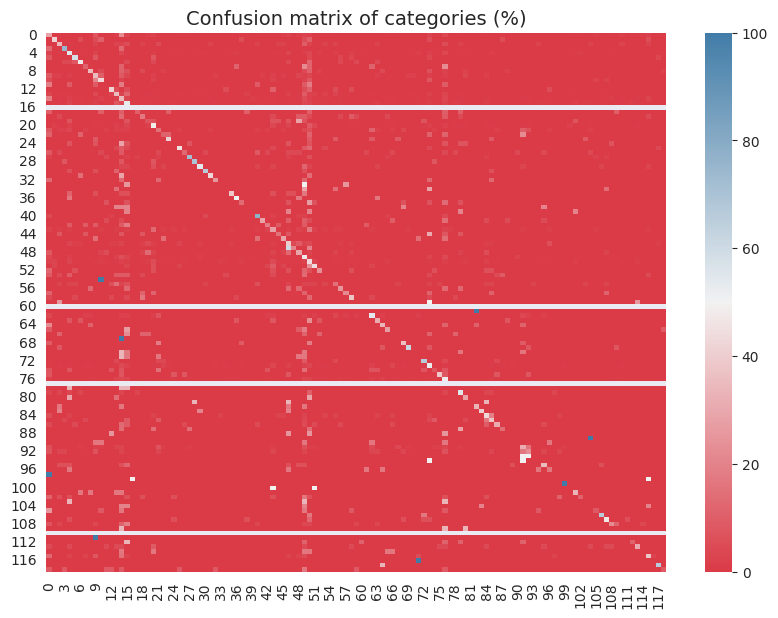

In [107]:
from sklearn import metrics
import seaborn as sns

import matplotlib.pyplot as plt
conf_matrix = metrics.confusion_matrix(all_predictions, y_raw)
conf_matrix = conf_matrix.astype(float)

for i in range(len(conf_matrix)):
    conf_matrix[i] = np.true_divide(conf_matrix[i],conf_matrix[i].sum())*100

df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(target_size-1)],
                     columns = [i for i in range(target_size-1)])
plt.figure(figsize = (10,7))
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)
sns.heatmap(df_cm, cmap=cmap)
# sns.heatmap(df_cm, annot=True, cmap=cmap)
plt.title("Confusion matrix of categories (%)", fontsize=14)
plt.show()

In [108]:
import unicodedata
unicodedata